<div style='text-align: center;'>
    <h1>CS6910 Fundamentals of Deep Learning</h1>
    <h2>Assignment-1</h2>
</div>

In [1]:
# Load all necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split

In [2]:
#Random seed to initiate initial weights and bias. 
#This decides the overall convergence of the model. 
np.random.seed(27) 

In [7]:
# Represents a layer (hidden or output) in the neural network.
class NeuralLayer:

    # Init the layer 
    def __init__(self, n_input, n_neurons, activation=None, weights=None, bias=None, method="random"):
        """
        This function initializes a NeuralLayer object.

        Args:
            n_input: The number of neurons in the previous layer (number of inputs for this layer).
            n_neurons: The number of neurons in this layer.
            activation: The activation function to be applied (e.g., sigmoid, tanh, relu). Defaults to sigmoid if not provided.
            weights: Pre-defined weights for the layer (optional). If not provided, they will be initialized using the chosen method.
            bias: Pre-defined bias for the layer (optional). If not provided, a random bias vector will be created.
            method: The weight initialization method ("random" or "xavier"). Defaults to "random".
        """

        self.activation = activation if activation is not None else 'sigmoid'
        self.weights = weights if weights is not None else self.initialize_weights(method, n_input, n_neurons)
        self.velocity = np.zeros_like(self.weights)
        self.m = np.zeros_like(self.weights)
        self.bias = bias if bias is not None else np.random.randn(n_neurons)
        self.timestep = 0
        self.last_activation = None
        self.error = None
        self.delta = None

    # Initialize weights using a specific method (random or xavier)
    def initialize_weights(self, method, n_input, n_neurons):
        """
        This function initializes the weights of the layer based on the chosen method.

        Args:
            method: The weight initialization method ("random" or "xavier").
            n_input: The number of neurons in the previous layer.
            n_neurons: The number of neurons in this layer.

        Returns:
            A numpy array containing the initialized weights.
        """

        if method == "xavier":
            limit = np.sqrt(2 / (n_input + n_neurons))
            return np.random.randn(n_input, n_neurons) * limit
        return np.random.randn(n_input, n_neurons)  # Random initialization

    # Activate the neural layer using the chosen activation function
    def activate(self, x):
        """
        This function performs the activation on the layer's inputs.

        Args:
            x: The input vector to the layer.

        Returns:
            The activated output of the layer.
        """

        r = np.dot(x, self.weights) + self.bias  # Weighted sum of inputs and bias
        self.last_activation = self._apply_activation(r)  # Apply activation function
        return self.last_activation

    # Apply the chosen activation function based on the layer's setting
    def _apply_activation(self, r):
        """
        This function applies the chosen activation function to the weighted sum of inputs and bias.

        Args:
            r: The weighted sum of inputs and bias before activation.

        Returns:
            The activated output based on the chosen activation function.
        """

        if self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-r))
        elif self.activation == 'tanh':
            return np.tanh(r)
        elif self.activation == 'relu':
            return np.maximum(0, r)
        elif self.activation == 'softmax':
            max_r = np.max(r, axis=1)
            max_r = max_r.reshape(max_r.shape[0], 1)
            exp_r = np.exp(r - max_r)
            return exp_r / np.sum(exp_r, axis=1).reshape(exp_r.shape[0], 1)
            
        return r  # Identity function if no activation specified

    # Apply the derivative of the activation function (used in backpropagation)
    def apply_activation_derivative(self, r):
        """
        This function calculates the derivative of the activation function used in the layer. 
        This derivative is essential for backpropagation during training to update weights and biases.

        Args:
            r: The weighted sum of inputs and bias before activation.

        Returns:
            The derivative of the activation function applied to 'r'.
        """

        if self.activation == 'sigmoid':
            return r * (1 - r)
        elif self.activation == 'tanh':
            return (1 - r**2)
        elif self.activation == 'relu':
            return np.where(r > 0, 1, 0)
        elif self.activation == 'softmax':
            # Reference: https://themaverickmeerkat.com/2019-10-23-Softmax/
            m, n = r.shape
            tensor1 = np.einsum('ij,ik->ijk', r, r)
            tensor2 = np.einsum('ij,jk->ijk', r, np.eye(n, n))  
            dSoftmax = tensor2 - tensor1
            return dSoftmax
        return r  # Identity function if no activation specified
    
    # Print information about the layer
    def __str__(self):
        return f'Neural Layer: {self.weights.shape} , {self.activation}'

In [8]:
# Represents a custom Neural Network
class NeuralNetwork:

    # Init the network
    def __init__(self, config):
        """
        This function initializes the neural network based on the provided configuration dictionary.

        Args:
          config: A dictionary containing the configuration parameters for the network. 
        """

        # Helper function to get configuration values with a default
        def get_value(key, default):
            return config[key] if key in config else default

        # Initialize empty list to store neural layers
        self._layers = []

        self.lr = get_value('learning_rate', 1e-3)  # Learning rate
        self.beta = get_value('beta', 0)  # Momentum parameter
        self.beta1 = get_value('beta1', 0)  # Adam optimizer parameter
        self.beta2 = get_value('beta2', 0)  # Adam optimizer parameter
        self.eps = get_value('epsilon', 0)  # Epsilon value for Adam optimizer
        self.epoch = get_value('epoch', 100)  # Number of training epochs
        self.criterion = get_value('criterion', 'cel')  # Loss function (e.g., cross-entropy)
        self.optimizer = get_value('optimizer', 'momentum')  # Optimization algorithm
        self.alpha = get_value('decay', 0)  # Regularization parameter
        self.regularization = get_value('regularization', 'L2')  # Regularization method
        self.weight_initialization = get_value('weight_initialization', 'random')  # Weight initialization method
        self.batch_size = get_value('batch_size', 16)  # Mini-batch size for training

        # Add layers to the network based on the configuration
        self._add_layers(config['input_size'], 
                         config['hidden_layers'], 
                         config['output_size'], 
                         config['neurons'],
                        config['activation'],
                        config['output_activation'])
    
    # Train the network
    def train(self, X_train, Y_train, X_val, Y_val, wandb_log = None, show_log = False):
        train_loss_hist = []
        train_accuracy_hist = []
        val_loss_hist = []
        val_accuracy_hist = []
        
        for epoch in range(self.epoch):
            for batch in range(0, X_train.shape[0], self.batch_size):
                # Get the batch of data
                X_batch = X_train[batch:batch+self.batch_size]
                Y_batch = Y_train[batch:batch+self.batch_size]
                
                # Forward pass
                Y_hat_batch = self.predict(X_batch)
                
                # Calculate training loss
                loss = self._criterion(Y_batch, Y_hat_batch)
                         
                # Backward pass
                self._backward(Y_hat_batch, Y_batch)
                
                # Update weight
                self._update_weights(X_batch)
            
            # Training
            Y_hat_train = self.predict(X_train)
            train_loss = self._criterion(Y_train, Y_hat_train)
            train_accuracy = np.sum(np.argmax(Y_hat_train, axis=1) == np.argmax(Y_train, axis=1)) / Y_train.shape[0]
            
            # Validation
            Y_hat_val = self.predict(X_val)
            val_loss = self._criterion(Y_val, Y_hat_val)
            val_accuracy = np.sum(np.argmax(Y_hat_val, axis=1) == np.argmax(Y_val, axis=1)) / Y_val.shape[0]
            
            if wandb_log is not None:
                wandb_log(epoch, train_loss, train_accuracy, val_loss, val_accuracy)
            
            if show_log:
                print("Epoch {} Train Loss {} Train Accuracy {} Val Loss {} Val Accuracy {}".format(epoch, train_loss, train_accuracy, val_loss, val_accuracy))
            
            train_loss_hist.append(train_loss)
            train_accuracy_hist.append(train_accuracy)
            val_loss_hist.append(val_loss)
            val_accuracy_hist.append(val_accuracy)
        return train_loss_hist, train_accuracy_hist, val_loss_hist, val_accuracy_hist
    
    # Predict the output
    def predict(self, x):
        """
        This function predicts the output of the neural network for a given input vector 'x'.

        Args:
          x: The input vector to be processed by the network.

        Returns:
          The predicted output vector of the network for the given input.
        """

        y_hat = self._forward(x)  # Perform forward pass
        return y_hat

    # Perform a forward pass (internal function)
    def _forward(self, x):
        """
        This function performs a forward pass through the neural network layers.

        Args:
          x: The input vector to be propagated through the network.

        Returns:
          The output vector after processing the input through all layers.
        """

        for layer in self._layers:
            x = layer.activate(x)  # Apply activation to the current input in each layer
        return x  # Return the final output after processing through all layers

    
    # Add layer
    def _add_layers(self, input_size, hidden_layers, output_size, neurons, activation, output_activation):
        """
        This function adds layers to the neural network based on the provided configuration.

        Args:
          input_size: The size of the input layer
          hidden_layers: The number of hidden layers
          output_size: The size of the output layer
          neurons: The number of neurons in each hidden layer
        """
        
        for i in range(0, hidden_layers+1):
            n_input = input_size if i==0 else neurons
            n_neurons = output_size if i==hidden_layers else neurons
            self._layers.append(NeuralLayer(
              n_input=n_input,
              n_neurons=n_neurons,
              activation= output_activation if i==hidden_layers else activation,
              method=self.weight_initialization
            ))
    
    # Backpropagation
    def _backward(self, y_hat, y):
        # Loop over the layers backward
        for i in reversed(range(len(self._layers))):
            layer = self._layers[i]
            # If this is the output layer
            if layer == self._layers[-1]:
                layer.error = y - y_hat
                if layer.activation == "softmax":
                    layer.delta = np.einsum('ijk,ik->ij', layer.apply_activation_derivative(y_hat), layer.error)
                else:
                    layer.delta = layer.error * layer.apply_activation_derivative(y_hat)
            else:
                next_layer = self._layers[i + 1]
                layer.error = np.dot(next_layer.delta, next_layer.weights.T)
                layer.delta = layer.error * layer.apply_activation_derivative(layer.last_activation)
    
    # Update weights
    def _update_weights(self, x):
        for i in range(len(self._layers)):
            layer = self._layers[i]
            # The input is either the previous layers output or input itself (for the first hidden layer)
            input_to_use = np.atleast_2d(x if i == 0 else self._layers[i - 1].last_activation)
            
            # Perform Gradient Descent and Regularization
            gradients = np.dot(input_to_use.T, layer.delta)
            
            # Update weights
            layer.weights -= (self._optimizer(gradients, layer) + self._regularisation(layer.weights))
            # Update biases
            layer.bias -= (self.lr * np.sum(layer.delta, axis=0) + self._regularisation(layer.bias))
            
    
    # Optimizer
    def _optimizer(self, gradients, layer):
        # Default update
        update = self.lr * gradients
        
        # Momentum based Gradient
        if self.optimizer == 'momentum':
            # Update velocity with momentum
            layer.velocity = self.beta * layer.velocity + update
            # Apply momentum update
            update = layer.velocity
        
        # Nesterov Accelerated Gradient
        elif self.optimizer == 'nag':
            # Have to work on this
            # Update velocity with momentum
            layer.velocity = self.beta * layer.velocity + update
            update = layer.velocity
        
        # RMSprop
        elif self.optimizer == 'rmsprop':
            # Update RMSprop variable
            layer.velocity = self.beta * layer.velocity + (1 - self.beta) * gradients**2
            # Apply RMSprop update
            update = update / np.sqrt(layer.velocity + self.eps)
        
        # Adam
        elif self.optimizer == 'adam':
            layer.timestep += 1
            # Compute m
            layer.m = self.beta1 * layer.m + (1 - self.beta1) * gradients
            # Correct bias in m
            m_corrected = layer.m / (1 - self.beta1**layer.timestep)
            # Compute v
            layer.velocity = self.beta2 * layer.velocity + (1 - self.beta2) * gradients**2
            # Correct bias in v
            v_corrected = layer.velocity / (1 - self.beta2**layer.timestep)
            # Apply Adam update
            update = self.lr * m_corrected / (np.sqrt(v_corrected) + self.eps)
        
        # Nadam
        elif self.optimizer == 'nadam':
            layer.timestep += 1
            # Compute m
            layer.m = self.beta1 * layer.m + (1 - self.beta1) * gradients
            # Correct bias in m
            m_corrected = layer.m / (1 - self.beta1**layer.timestep)
            # Compute v
            layer.velocity = self.beta2 * layer.velocity + (1 - self.beta2) * gradients**2
            # Correct bias in v
            v_corrected = layer.velocity / (1 - self.beta2**layer.timestep)
            # Apply Nadam update
            update = self.beta1*m_corrected + ((1-self.beta1)/(1-self.beta1**layer.timestep))*gradients
            update = (self.lr/(np.sqrt(v_corrected) + self.eps))*update
        return update            
    
    
    # Apply regularization
    def _regularisation(self, w):
        """
        This function calculates the regularization penalty based on the chosen method (L1 or L2).

        Args:
          w: The weight matrix of a layer to be regularized.

        Returns:
          The calculated regularization penalty value.
        """

        update = 0
        if self.regularization == "L1":
            """
            L1 Regularization:
              Applies a penalty proportional to the absolute sum of the weights.
            """
            update = self.lr * self.alpha * np.sum(np.abs(w))
        elif self.regularization == "L2":
            """
            L2 Regularization:
              Applies a penalty proportional to the squared sum of the weights.
            """
            update = 0.5 * self.lr * self.alpha * np.sum(w**2)
        return update

    
    # Calculate the loss
    def _criterion(self, y, y_hat):
        """
        This function calculates the loss based on the chosen criterion (loss function).

        Args:
          y: The true target output vector.
          y_hat: The predicted output vector of the network.

        Returns:
          The calculated loss value.
        """

        if self.criterion == 'mse':
            """
            Mean Squared Error (MSE) loss function:
              Calculates the average squared difference between the target and predicted outputs.
            """
            mse = np.mean(np.square(y - y_hat)) / 2
            return mse
        elif self.criterion == 'cel':
            """
            Cross-entropy loss function:
              Measures the difference between the probability distribution of the target and the predicted output.
            """
            epsilon = 1e-12
            y_hat = np.clip(y_hat, epsilon, 1. - epsilon)
            N = y_hat.shape[0]
            ce = -np.sum(y*np.log(y_hat+1e-9))/N
            return ce
        return 0  # Default to zero loss if no valid criterion is specified


In [9]:
# Flatten the images
train_images = train_images.reshape(train_images.shape[0], 784) / 255

# Encode the labels
train_labels = np.eye(10)[train_labels]

# Prepare data for training and validation
images_train, images_val, labels_train, labels_val = train_test_split(train_images, train_labels, test_size=0.1, shuffle=True, random_state=27)

In [10]:
# Network Config
network_config = {
    'input_size': 2,
    'output_size': 1,
    'hidden_layers': 1,
    'neurons':3,
    'activation':'sigmoid',
    'output_activation':'sigmoid',
    'learning_rate': 0.1,
    'beta': 0.9,
    'beta1': 0.9,
    'beta2':0.9999,
    'epsilon': 1e-8,
    'epoch': 10,
    'optimizer': "sgd",
    'criterion': "cel",
    'decay': 1e-9,
    'regularization': "L2",
    'weight_initialization': "random",
    'batch_size': 2,
}

#Dataset XOR
inputs = np.array([[0, 0], [0, 1], [1, 0], [1, 1], [0, 0], [0, 1], [1, 0], [1, 1]])
output = np.array([[0], [1], [1], [0], [0], [1], [1], [0]])

nn = NeuralNetwork(network_config)
        
tl, ta, vl, va = nn.train(inputs, output, inputs, output, wandb_log = None, show_log = True)

Epoch 0 Train Loss 0.1713213134252855 Train Accuracy 1.0 Val Loss 0.1713213134252855 Val Accuracy 1.0
Epoch 1 Train Loss 0.1598596510450127 Train Accuracy 1.0 Val Loss 0.1598596510450127 Val Accuracy 1.0
Epoch 2 Train Loss 0.14859114380080335 Train Accuracy 1.0 Val Loss 0.14859114380080335 Val Accuracy 1.0
Epoch 3 Train Loss 0.1376533405438783 Train Accuracy 1.0 Val Loss 0.1376533405438783 Val Accuracy 1.0
Epoch 4 Train Loss 0.12716762526227166 Train Accuracy 1.0 Val Loss 0.12716762526227166 Val Accuracy 1.0
Epoch 5 Train Loss 0.11723243872917896 Train Accuracy 1.0 Val Loss 0.11723243872917896 Val Accuracy 1.0
Epoch 6 Train Loss 0.10791927118650277 Train Accuracy 1.0 Val Loss 0.10791927118650277 Val Accuracy 1.0
Epoch 7 Train Loss 0.09927171805488595 Train Accuracy 1.0 Val Loss 0.09927171805488595 Val Accuracy 1.0
Epoch 8 Train Loss 0.09130726809565057 Train Accuracy 1.0 Val Loss 0.09130726809565057 Val Accuracy 1.0
Epoch 9 Train Loss 0.08402105960714149 Train Accuracy 1.0 Val Loss 0.0

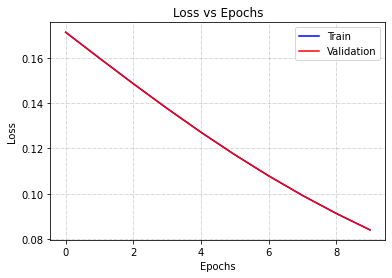

In [11]:
# Plot changes in loss
plt.plot(tl, c = 'b', label = 'Train')
plt.plot(vl, c = 'r', label = 'Validation')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(linestyle='-.', linewidth=0.5)
plt.legend()
plt.show()

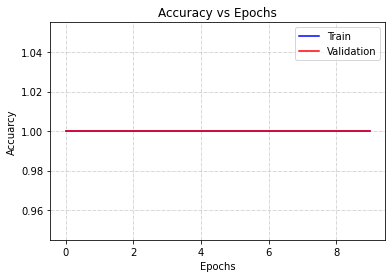

In [12]:
# Plot changes in accuracy
plt.plot(ta, c = 'b', label = 'Train')
plt.plot(va, c = 'r', label = 'Validation')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuarcy')
plt.grid(linestyle='-.', linewidth=0.5)
plt.legend()
plt.show()

In [13]:
# Network Config
network_config = {
    'input_size': 784,
    'output_size': 10,
    'hidden_layers': 4,
    'neurons':128,
    'activation':'relu',
    'output_activation':'softmax',
    'learning_rate': 0.0001,
    'beta': 0.9,
    'beta1': 0.9,
    'beta2':0.9999,
    'epsilon': 1e-8,
    'epoch': 10,
    'optimizer': "adam",
    'criterion': "cel",
    'decay': 0.0005,
    'regularization': "L1",
    'weight_initialization': "random",
    'batch_size': 64,
}

nn = NeuralNetwork(network_config)
        
tl, ta, vl, va = nn.train(images_train, labels_train, images_val, labels_val, wandb_log = None, show_log = True)

Epoch 0 Train Loss 12.071634874654851 Train Accuracy 0.09977777777777778 Val Loss 12.0406007291029 Val Accuracy 0.102
Epoch 1 Train Loss 12.209033687767336 Train Accuracy 0.09977777777777778 Val Loss 12.196905026686595 Val Accuracy 0.102
Epoch 2 Train Loss 13.779787259215034 Train Accuracy 0.09977777777777778 Val Loss 13.777868637637129 Val Accuracy 0.102
Epoch 3 Train Loss 14.242948425545203 Train Accuracy 0.09977777777777778 Val Loss 14.236207531528443 Val Accuracy 0.102
Epoch 4 Train Loss 14.478431335644311 Train Accuracy 0.09977777777777778 Val Loss 14.469207365230476 Val Accuracy 0.102
Epoch 5 Train Loss 14.641445086296885 Train Accuracy 0.09977777777777778 Val Loss 14.630495612734235 Val Accuracy 0.102
Epoch 6 Train Loss 14.767576540902809 Train Accuracy 0.09977777777777778 Val Loss 14.755291083931185 Val Accuracy 0.102
Epoch 7 Train Loss 14.871036398315328 Train Accuracy 0.09977777777777778 Val Loss 14.85765476767718 Val Accuracy 0.102
Epoch 8 Train Loss 14.95901753190395 Train 

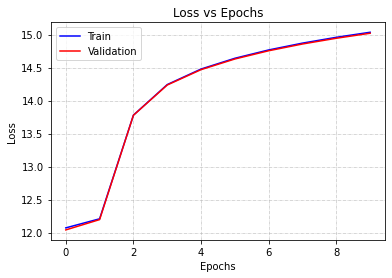

In [14]:
# Plot changes in loss
plt.plot(tl, c = 'b', label = 'Train')
plt.plot(vl, c = 'r', label = 'Validation')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(linestyle='-.', linewidth=0.5)
plt.legend()
plt.show()

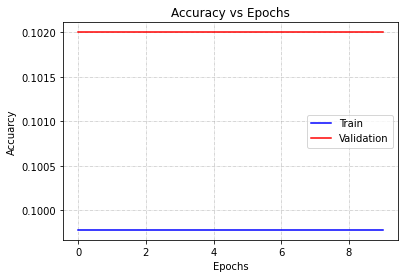

In [15]:
# Plot changes in accuracy
plt.plot(ta, c = 'b', label = 'Train')
plt.plot(va, c = 'r', label = 'Validation')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuarcy')
plt.grid(linestyle='-.', linewidth=0.5)
plt.legend()
plt.show()

### **Remarks**

The above idea works when handling a single data point at a time but couldn't do better with batch sized input. And implementation wise the backward propagation and optimization is coupled with the network class making it very difficult to make changes and implement sweep function. Overall, it couldn't yield better results.

A few things need to be changed:

1. Change NeuralNetwork into class which defines a neural network and performs forward and backward pass only.
2. Optimizers should be made as a separate class and maintain velocity and corrected variabled in this class.
3. Criterions should be made as separate class.